In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the correct path
data = pd.read_csv(r'D:\postpartum-care-platform - Copy\ml\datasets\ppd\post natal data.csv')

# Data Cleaning
# Handle missing values (empty strings and 'Not interested to say' responses)
data.replace(['', 'Not interested to say', 'Maybe'], np.nan, inplace=True)

# Convert 'Age' to numerical by taking the midpoint of each range
def age_to_numeric(age_str):
    if pd.isna(age_str):
        return np.nan
    if '-' in age_str:
        low, high = map(int, age_str.split('-'))
        return (low + high) / 2
    return float(age_str)

data['Age'] = data['Age'].apply(age_to_numeric)

# Encode the target variable - considering 'Suicide attempt' as the primary indicator of severe PPD
# We'll create a binary target where 'Yes' indicates high risk of PPD
data['PPD_Risk'] = data['Suicide attempt'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select features - using all survey responses as potential predictors
features = [
    'Age', 'Feeling sad or Tearful', 'Irritable towards baby & partner', 
    'Trouble sleeping at night', 'Problems concentrating or making decision',
    'Overeating or loss of appetite', 'Feeling anxious', 'Feeling of guilt',
    'Problems of bonding with baby'
]

In [2]:
# Preprocess features
# Convert categorical features to numerical using label encoding
label_encoders = {}
for feature in features[1:]:  # Skip 'Age' which is already numeric
    le = LabelEncoder()
    # Fit on all possible values (including those that might be missing in train set)
    unique_values = data[feature].dropna().unique()
    le.fit(unique_values)
    data[feature] = data[feature].map(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)
    label_encoders[feature] = le

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(data[features])
y = data['PPD_Risk'].values


In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Build Random Forest model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Important since we likely have class imbalance
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

print("Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.9467849223946785

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       313
           1       0.92      0.91      0.91       138

    accuracy                           0.95       451
   macro avg       0.94      0.94      0.94       451
weighted avg       0.95      0.95      0.95       451



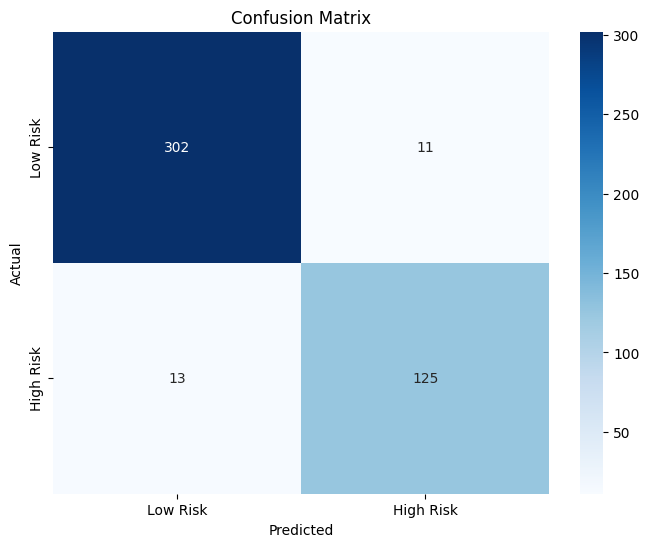

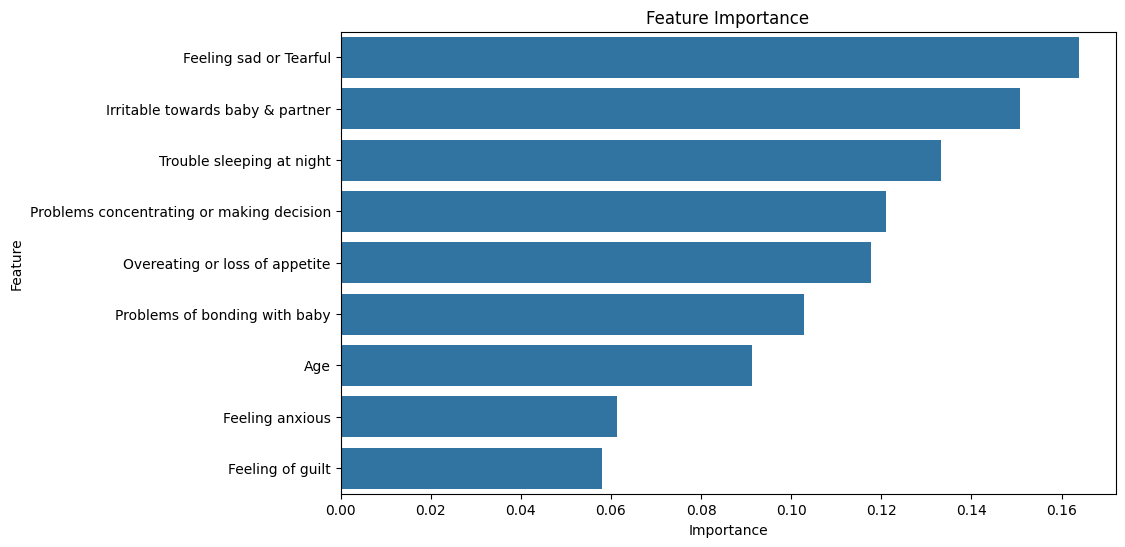

In [4]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Risk', 'High Risk'], 
            yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [5]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Create grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1'  # Good metric for imbalanced classes
)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\nOptimized Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Optimized Model Evaluation:
Accuracy: 0.9689578713968958

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       313
           1       0.96      0.94      0.95       138

    accuracy                           0.97       451
   macro avg       0.97      0.96      0.96       451
weighted avg       0.97      0.97      0.97       451



In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import joblib  # To save/load the model

# Load dataset
data = pd.read_csv(r'D:\postpartum-care-platform - Copy\ml\datasets\ppd\post natal data.csv')

# Clean data
data.replace(['', 'Not interested to say'], np.nan, inplace=True)  # Keep "Maybe" as a valid response

# Convert 'Age' to numerical (midpoint of range)
def age_to_numeric(age_str):
    if pd.isna(age_str):
        return np.nan
    if '-' in age_str:
        low, high = map(int, age_str.split('-'))
        return (low + high) / 2
    return float(age_str)

data['Age'] = data['Age'].apply(age_to_numeric)

# Define target variable (PPD Risk: 1 if 'Yes' to suicide attempt, else 0)
data['PPD_Risk'] = data['Suicide attempt'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select features
features = [
    'Age',
    'Feeling sad or Tearful',
    'Irritable towards baby & partner',
    'Trouble sleeping at night',
    'Problems concentrating or making decision',
    'Overeating or loss of appetite',
    'Feeling anxious',
    'Feeling of guilt',
    'Problems of bonding with baby'
]

# Encode categorical features
label_encoders = {}
for feature in features[1:]:  # Skip 'Age'
    le = LabelEncoder()
    unique_values = data[feature].dropna().unique()
    le.fit(unique_values)
    data[feature] = data[feature].map(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)
    label_encoders[feature] = le

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(data[features])
y = data['PPD_Risk'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Save model & encoders
joblib.dump(model, 'ppd_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(imputer, 'imputer.pkl')

['imputer.pkl']

In [9]:
# === Screening Function ===

def conduct_ppd_screening():
    # Load model and encoders
    model = joblib.load('ppd_model.pkl')
    label_encoders = joblib.load('label_encoders.pkl')
    imputer = joblib.load('imputer.pkl')

    print("\n=== Postpartum Depression (PPD) Screening Tool ===")
    print("Please answer based on how you've felt in the past 2 weeks:\n")

    questions = [
        ("Age (years)", "numerical"),
        ("Have you felt sad or tearful?", ["No", "Yes", "Sometimes"]),
        ("Have you felt irritable towards your baby or partner?", ["No", "Yes", "Sometimes"]),
        ("How often have you had trouble sleeping at night?", ["No", "Yes", "Two or more days a week"]),
        ("Have you had problems concentrating or making decisions?", ["No", "Yes", "Often"]),
        ("Have you had changes in appetite (overeating or loss of appetite)?", ["No", "Yes", "Not at all"]),
        ("Have you felt anxious?", ["No", "Yes"]),
        ("Have you felt excessive guilt?", ["No", "Yes", "Maybe"]),
        ("Have you had difficulty bonding with your baby?", ["No", "Yes", "Sometimes"]),
    ]

    answers = []

    # Collect responses
    for i, (question, options) in enumerate(questions):
        if options == "numerical":
            while True:
                try:
                    age = float(input(f"{i+1}. {question}: "))
                    if 15 <= age <= 50:
                        answers.append(age)
                        break
                    else:
                        print("Please enter a valid age (15-50).")
                except ValueError:
                    print("Please enter a number.")
        else:
            print(f"\n{i+1}. {question}")
            for j, option in enumerate(options):
                print(f"   {j+1}. {option}")
            while True:
                try:
                    choice = int(input("Your choice (1-{}): ".format(len(options))))
                    if 1 <= choice <= len(options):
                        answers.append(options[choice - 1])
                        break
                    else:
                        print("Invalid choice. Try again.")
                except ValueError:
                    print("Please enter a number.")

    # Prepare input data
    input_data = [answers[0]]  # Age
    for i, feature in enumerate(features[1:]):
        le = label_encoders[feature]
        user_input = answers[i + 1]
        if user_input in le.classes_:
            input_data.append(le.transform([user_input])[0])
        else:
            print(f"\n⚠️ Warning: '{user_input}' not seen during training for '{feature}'. Treated as missing.")
            input_data.append(np.nan)

    # Impute missing values
    input_data = imputer.transform([input_data])

    # Predict
    risk_prob = model.predict_proba(input_data)[0][1]
    risk_level = "High" if risk_prob > 0.7 else "Moderate" if risk_prob > 0.4 else "Low"

    # Show result
    print("\n=== Screening Result ===")
    print(f"PPD Risk Level: {risk_level}")
    print(f"Probability: {risk_prob:.1%}")

    if risk_level == "High":
        print("\n🚨 Seek immediate help from a healthcare provider.")
        print("You may be at high risk for postpartum depression.")
    elif risk_level == "Moderate":
        print("\n⚠️ Consider discussing your symptoms with a doctor.")
        print("Monitoring is recommended.")
    else:
        print("\n✅ Your risk appears low, but stay aware of changes.")

    print("\nFor support, contact:")
    print("- Postpartum Support International: 1-800-944-4773")
    print("- National Suicide Prevention Lifeline: 988")

# Run screening
if __name__ == "__main__":
    conduct_ppd_screening()


=== Postpartum Depression (PPD) Screening Tool ===
Please answer based on how you've felt in the past 2 weeks:


2. Have you felt sad or tearful?
   1. No
   2. Yes
   3. Sometimes

3. Have you felt irritable towards your baby or partner?
   1. No
   2. Yes
   3. Sometimes

4. How often have you had trouble sleeping at night?
   1. No
   2. Yes
   3. Two or more days a week

5. Have you had problems concentrating or making decisions?
   1. No
   2. Yes
   3. Often

6. Have you had changes in appetite (overeating or loss of appetite)?
   1. No
   2. Yes
   3. Not at all

7. Have you felt anxious?
   1. No
   2. Yes

8. Have you felt excessive guilt?
   1. No
   2. Yes
   3. Maybe

9. Have you had difficulty bonding with your baby?
   1. No
   2. Yes
   3. Sometimes

=== Screening Result ===
PPD Risk Level: Low
Probability: 34.5%

✅ Your risk appears low, but stay aware of changes.

For support, contact:
- Postpartum Support International: 1-800-944-4773
- National Suicide Prevention Li

d:\postpartum-care-platform - Copy\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import joblib
from pathlib import Path

# 1. Load and prepare data
data = pd.read_csv(r'D:\postpartum-care-platform - Copy\ml\datasets\ppd\post natal data.csv')
data.replace(['', 'Not interested to say'], np.nan, inplace=True)

# Age conversion
def age_to_numeric(age_str):
    if pd.isna(age_str): return np.nan
    if '-' in age_str:
        low, high = map(int, age_str.split('-'))
        return (low + high) / 2
    return float(age_str)

data['Age'] = data['Age'].apply(age_to_numeric)

# Target variable
data['PPD_Risk'] = data['Suicide attempt'].apply(lambda x: 1 if x == 'Yes' else 0)

# 2. Feature engineering
features = [
    'Age',
    'Feeling sad or Tearful',
    'Irritable towards baby & partner',
    'Trouble sleeping at night',
    'Problems concentrating or making decision',
    'Overeating or loss of appetite',
    'Feeling anxious',
    'Feeling of guilt',
    'Problems of bonding with baby'
]

# 3. Preprocessing
label_encoders = {}
for feature in features[1:]:  # Skip 'Age'
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature].astype(str))
    label_encoders[feature] = le

imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(data[features])
y = data['PPD_Risk'].values

# 4. Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)  # THIS DEFINES THE MODEL VARIABLE

# 5. Save all artifacts
model_dir = Path('ppd_model_artifacts')
model_dir.mkdir(exist_ok=True)

joblib.dump({
    'model': model,  # Now properly defined
    'label_encoders': label_encoders,
    'imputer': imputer,
    'features': features,
    'questions': [
        ("Age (years)", "numerical"),
        ("Have you felt sad or tearful?", ["No", "Yes", "Sometimes"]),
        ("Have you felt irritable towards baby & partner?", ["No", "Yes", "Sometimes"]),
        ("Trouble sleeping at night?", ["No", "Yes", "Two or more days a week"]),
        ("Problems concentrating?", ["No", "Yes", "Often"]),
        ("Appetite changes?", ["No", "Yes", "Not at all"]),
        ("Feeling anxious?", ["No", "Yes"]),
        ("Excessive guilt?", ["No", "Yes", "Maybe"]),
        ("Difficulty bonding with baby?", ["No", "Yes", "Sometimes"])
    ]
}, model_dir/'ppd_model_bundle.pkl')

print(f"✅ Model saved to {model_dir}/")
print(f"Model accuracy: {model.score(X_test, y_test):.2f}")

✅ Model saved to ppd_model_artifacts/
Model accuracy: 0.95


In [8]:
from joblib import dump
dump(model, 'ppd_risk_model.joblib')

['ppd_risk_model.joblib']

In [11]:
from joblib import dump

# Save the model
dump(model, 'ppd_model.joblib')

# Save the preprocessing objects
dump(label_encoders, 'label_encoders.joblib')
dump(imputer, 'imputer.joblib')

# Save the feature list
import json
with open('features.json', 'w') as f:
    json.dump(features, f)